## Preparations

### Imports

In [1]:
import numpy as np
from matplotlib.pyplot import get_cmap
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
from boston_ds import BostonDS
from drift_detection.drift_testers.ks_drift_tester import KsDriftTester
from helpers.data_helper import sample_from_data, change_int_values
from helpers.model_helper import XgbModel
from helpers.utils import calc_perf_kpis

from drift_detection.drift_detector import DriftDetector


D:\docs\Study\DSML_IDC\Semester5\MLOps\Project\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare Boston data for demo

In [2]:

# ============================================================= Initial data setup
# Load and prep boston data
boston = BostonDS()

x = boston.x
y = boston.y
x_cont_features = boston.cont_features
x_int_features = boston.int_features
x_cat_features = boston.cat_features

# from entire dataset, choose subset for initial train/test
TRAIN_TEST_SIZE = 520
x_sample, y_sample = sample_from_data(x, y, TRAIN_TEST_SIZE)
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4, random_state=10)

display(x_train.head())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
776,0.088046,20.0,6.96,0,0.46517,5.856,42.400644,4.4532,3,223,18.6,388.65,13.0
1662,2.880211,0.0,19.58,0,0.869709,4.903,97.536475,1.334057,5,403,14.7,396.9,29.29
948,5.56614,0.0,18.1,0,0.739608,6.219,99.544231,2.0139,24,666,20.2,395.69,16.59
436,14.470336,0.0,18.1,0,0.739218,6.461,93.624468,2.061805,24,666,20.2,27.49,18.05
512,-0.052336,12.5,7.87,0,0.521775,6.012,66.591985,5.559066,5,311,15.2,395.6,12.43


## Train Step

### Model train

In [3]:

# ============================================================= Train step
# Build model on train data
model = XgbModel()
model.fit(x_train, y_train)


### Drift detector configuration and train

**Creates a drift detector and auto-select and fit drift testers based on feature types:**
* Numeric features - Kolmogorov–Smirnov tester
* Categorical tests - Chi^2 tester
* All together - KL Divergence (Multivariable) tester

All testers default with pval=0.005, with three conseq. failures.

In [4]:
# Create Feature drift detector with all default testers
drift_detector = DriftDetector()
drift_detector.autoselect_testers(x_cont_features, x_int_features, x_cat_features)
drift_detector.fit(x_train)

In [5]:
tests_in_detector = drift_detector.drift_test_set.get_test_names()
print('Testers in drif detector: ', len(tests_in_detector),'\n', tests_in_detector)

Testers in drif detector:  14 
 ['ks_CRIM', 'ks_ZN', 'ks_INDUS', 'ks_NOX', 'ks_RM', 'ks_AGE', 'ks_DIS', 'ks_PTRATIO', 'ks_B', 'ks_LSTAT', 'ks_RAD', 'ks_TAX', 'chi_CHAS', 'kl_div']


**In Advanced mode - user can select other testers, p-vals, conseq failures.**

Univariate testers:
* Kolmogorov–Smirnov
* Chi^2

Multivariate testers:
* Multivariate KL Divergence with autofit
* Multivariate MMD (Max Mean Divergence) with autofit
* Multivatiate KS over PCA


### Collect data for plots later

In [6]:
# Initial predction / drift test plan
y_pred = model.predict(x_test)
drift_test_results = drift_detector.test_drift(x_test)

In [7]:
# Calc and store initial model performance KPIs on test
kpi = calc_perf_kpis(x_test, y_test, y_pred)
kpi['drift_detected'] = drift_test_results['drift_detected']
kpi['test_exceptions'] = drift_test_results['test_exceptions']

perf_kpis = pd.DataFrame(columns=kpi.keys()).append(kpi, ignore_index=True)

In [8]:
# Add control plots data collector
control_data = {}
for tester_name in drift_detector.drift_test_set.get_test_names():
    df = pd.DataFrame(columns=['threshold', 'value'])
    control_data[tester_name] = df

## Runtime step

In [9]:
# ============================================================= Runtime step
number_of_batches = 300
start_drift_at_batch = 100
sample_size = 50


# Runtime loop
for i in range(number_of_batches):
    # Sample batch from data (No drift yet)
    x_sample, y_sample = sample_from_data(x, y, sample_size)

    # modify data batch to create feature drift
    if i > start_drift_at_batch:
        x_sample['RM'] = x_sample['RM'] + x['RM'].std() * 0.01 * (i - start_drift_at_batch)
        x_sample['LSTAT'] = x_sample['LSTAT'] + x['LSTAT'].std() * 0.01 * (i - start_drift_at_batch)
        x_sample = change_int_values(x_sample, 'CHAS', 0, 1, 0.01 * (i - start_drift_at_batch))


    # predict
    y_pred = model.predict(x_sample)
        
    # Execute drift test
    drift_test_results = drift_detector.test_drift(x_sample)

    # calc RMSE (For demo only, cannot do in real runtime - no labels there
    kpi_sample = calc_perf_kpis(x_sample, y_sample, y_pred)

    # Collect data for plots later on
    kpi_sample['drift_detected'] = drift_test_results['drift_detected']
    kpi_sample['test_exceptions'] = drift_test_results['test_exceptions']
    perf_kpis = perf_kpis.append(kpi_sample, ignore_index=True)
    
    # Get data for control charts
    for tester in drift_detector.drift_test_set.drift_testers:
        control_record = {
            'threshold': tester.get_threshold(),
            'value': tester.last_value}

        control_data[tester.test_name] = control_data[tester.test_name].append(control_record, ignore_index=True)


## Plot RMSE and detection results

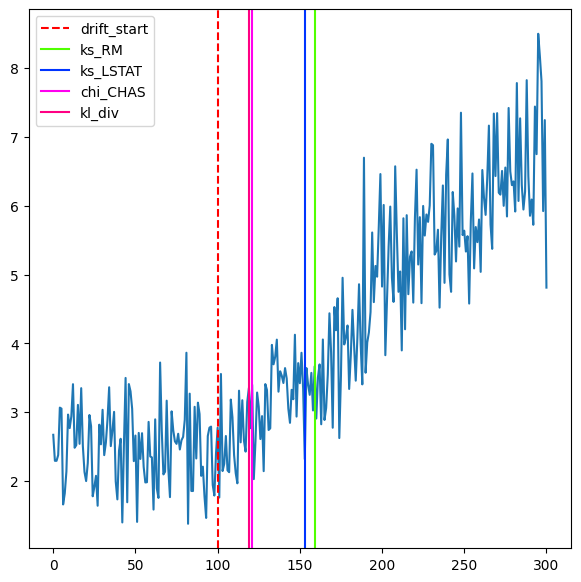

In [10]:

# ========================================================================== Plot

fig, axs = plt.subplots(figsize=(7, 7))

# plot RMSE (Loss function) line
axs.plot(perf_kpis['RMSE'])

# plot vertical lin for data drift start point
axs.axvline(x=start_drift_at_batch, label='drift_start', color='r', linestyle='dashed')

# Get drift detector x_history for plots
x_history = drift_detector.history_df

# plot vertical line for each tester that fired
fail_detections = []
cmap = get_cmap('hsv', 15)

for i, test_name in enumerate(drift_detector.get_test_names()):
    if x_history[test_name].sum() > 0:
        detection_time = np.where(x_history[test_name] == True)[0].min()
        axs.axvline(x=detection_time, label=test_name, color=cmap(i))

# Display plot
axs.legend()
plt.show()

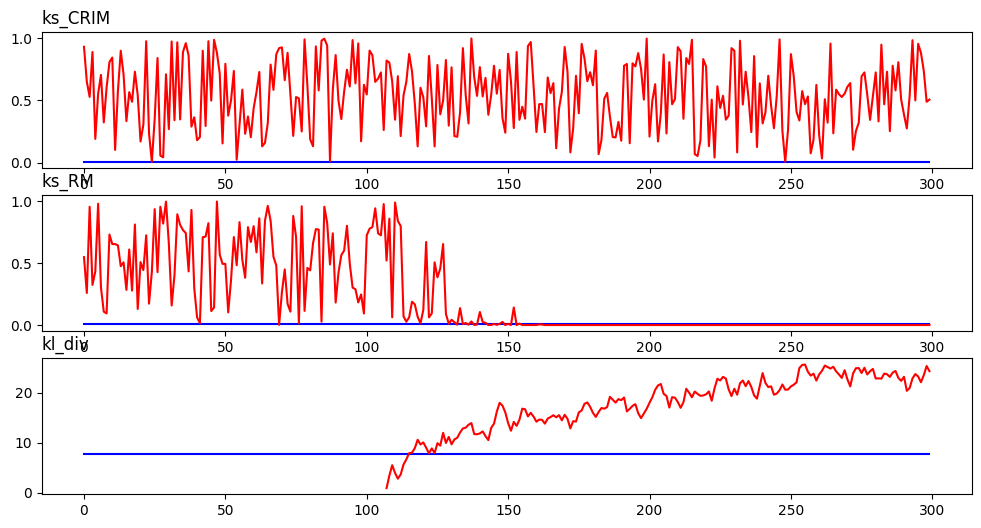

In [11]:

# ==============================================================Plot control 
plots_to_display = ['ks_CRIM', 'kl_div', 'ks_RM']
n_testers = len(plots_to_display)
fig, axs = plt.subplots(n_testers, figsize=(12, 2*n_testers))
i = 0

for item in control_data.items():
    if item[0] in plots_to_display:
        axs[i].plot(item[1].iloc[:, 0], color='b')
        axs[i].plot(item[1].iloc[:, 1], color='r')
        axs[i].set_title(item[0], loc='left')
        i += 1

plt.show()

In [12]:
display(perf_kpis)


,R_sq,ajd_R_sq,MAE,MSE,RMSE,drift_detected,test_exceptions
0,0.921515,0.916255,1.615454,1.615454,2.671996,False,[]
1,0.918126,0.888560,1.328774,1.328774,2.293883,False,[]
2,0.958415,0.943399,1.415328,1.415328,2.293893,False,[]
3,0.915963,0.885616,1.502882,1.502882,2.377450,False,[]
4,0.805971,0.735905,1.567796,1.567796,3.067068,False,[]
...,...,...,...,...,...,...,...
296,0.461932,0.267630,6.484398,6.484398,8.177951,True,"[ks_RM, ks_LSTAT, kl_div]"
297,0.313166,0.065142,5.965391,5.965391,7.811118,True,"[ks_RM, ks_LSTAT, kl_div]"
298,0.468897,0.277110,5.013640,5.013640,5.923910,True,"[ks_RM, ks_LSTAT, kl_div]"
299,0.530721,0.361260,5.793783,5.793783,7.246116,True,"[ks_RM, ks_LSTAT, kl_div]"
